In [2]:
import csv
import json
from pprint import pprint
import datetime
import requests
import pandas as pd

### Svenska kraftnät Nätområden

In [4]:
# source: https://www.natomraden.se/

files = ['./SE1.json', './SE2.json', './SE3.json','./SE4.json']
areas = []
for fname in files:
    with open(fname, mode='r') as f:
        areas += json.load(f)

data = [{'id': a['properties']['id'], 
      'name': a['properties']['namn'], 
      'company': a['properties']['bolag'], 
      'center_lat': a['properties']['center'][0],
      'center_lon': a['properties']['center'][1],
      'area': a['properties']['snitt'],
      'polygon': a['geometry']['coordinates'][0]} for a in areas]
df_areas = pd.DataFrame(data).set_index("id")
df_areas.to_excel("./all_areas.xlsx")
df_areas.to_csv("./all_areas.csv")

In [5]:
#load data with cloab
raw_link = 'https://raw.githubusercontent.com/rebaseenergy/svk-data/main/all_areas.csv'
df_areas = pd.read_csv(raw_link)
df_areas.head()

,id,area,center_lat,center_lon,company,name,polygon
0,AJB,1,66.157699,17.858282,Vattenfall Eldistribution AB,Arvidsjaurbygden,"[[20.23361939321, 65.662917068984], [20.217048..."
1,BDN,1,66.059860,21.279649,Bodens Energi Nät AB,Boden,"[[21.939938351992, 66.332329969747], [21.87916..."
2,JUJ,1,67.785701,21.014726,Jukkasjärvi Sockens Belysningsf,Jukkasjärvi,"[[21.313742720138, 67.945159478693], [21.31135..."
3,KAB,1,65.973472,23.252347,Vattenfall Eldistribution AB,Kalixbygden,"[[23.567971051618, 66.285317994081], [23.60838..."
4,KLK,1,67.850554,20.193530,LKAB Nät AB,Kiruna LKAB,"[[[20.203713997003, 67.866671566003], [20.2058..."


### Svenska kraftnät Mimer

The Swedish TSO SVK is publishing data about consumption for different grid regions on the website [Mimer](https://mimer.svk.se/ConsumptionProfile/ConsumptionProfileIndex). The electricty demand data available is:

* Planerad (planned) [kWh/h]
* Avräknad (actual) [kWh/h]

However, the demand data (forecasted) wind power is only availabe until 2017-09-25 23:00 for some reason. The time stamps given at Mimer is given for the start of the considered interval, meaning 10:00 refers to the interval 10:00-11:00. Furthermore, it is given in Swedish normal time, meaning no correction of daylight saving time. Meaning to convert to UTC we need to remove one hour. "

In [66]:
def download_mimer_data(date_start, date_end, areas):
    dfs = []
    url_base = 'https://mimer.svk.se/'
    for area in areas: 
        url_target = 'ConsumptionProfile/DownloadText?groupByType=0&' + \
                     'PeriodFrom='+date_start.split('-')[1]+'%2F'+date_start.split('-')[2]+'%2F'+date_start.split('-')[0]+'%2000%3A00%3A00&' + \
                     'PeriodTo='+date_end.split('-')[1]+'%2F'+date_end.split('-')[2]+'%2F'+date_end.split('-')[0]+'%2000%3A00%3A00&' + \
                     'networkAreaIdString='+area
        
        url = url_base+url_target
        r = requests.get(url)
        decoded_content = r.content.decode('utf-8')
        csv_file = csv.reader(decoded_content.splitlines(), delimiter=';')
        rows = list(csv_file)
        rows = rows[1:-1] # Remove first and last line

        date, data = [], []
        for row in rows: 
            date.append(row[0])
            data.append(-float(row[1].replace(',', '.')))

        df = pd.DataFrame(data=data, index=date, columns=[area])
        df.index = pd.to_datetime(df.index)-datetime.timedelta(hours=1)
        df.index = df.index.tz_localize('UTC')
        dfs.append(df)

    df_SE = pd.concat(dfs, axis=1, join='outer')
    
    return df_SE

In [67]:
date_start = '2019-10-01'
date_end = '2020-11-10'
areas = ['AVE']
df_SE = download_mimer_data(date_start, date_end, areas)

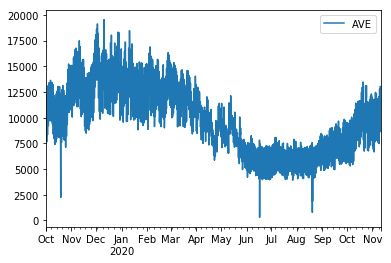

In [68]:
df_SE.plot()

### Energimarknadsinspektionen

In [93]:
url = 'https://www.ei.se/Documents/Publikationer/arsrapporter/el/sammanstsllningar_over_elnatsforetagens_tariffer/Storre_sakringskunder.xlsx'
df = pd.read_excel(url, sheet_name='35A, 30 000 kWh', header=[4,6])

In [98]:
df#.iloc[:,0]

35A, 30 000 kWh/år                                               \
               REnummer                                  Nätföretag   
0              REL00018                    AB Borlänge Energi Elnät   
1              REL00149                               AB PiteEnergi   
2              REL00091          Affärsverken Elnät i Karlskrona AB   
3              REL00001                             Ale El ek. för.   
4              REL00002                      Alingsås Energi Nät AB   
5              REL00003                              Almnäs Bruk AB   
6              REL00004                            Alvesta Elnät AB   
7              REL00005                            Arvika Teknik AB   
8              REL00007                    Bengtsfors Energi Nät AB   
9              REL00008               Bergs Tingslags Elektriska AB   
10             REL00010                        Bjäre Kraft ek. för.   
11             REL00014                              Blåsjön Nät AB   
12             REL00015                        Bodens Energi Nät AB   
13             REL00016                         Boo Energi ek. för.   
14             REL00017                    Borgholm Energi Elnät AB   
15             REL00019                              Borås Elnät AB   
16             REL00101                         Brittedals Elnät AB   
17             REL00020                   Brittedals Elnät ek. för.   
18             REL01012                   Brittedals Elnät ek. för.   
19             REL00021               Bromölla Energi och Vatten AB   
20             REL00023                                 C4 Elnät AB   
21             REL00181                               Dala Elnät AB   
22             REL00869                        Dala Energi Elnät AB   
23             REL03009                        Dala Energi Elnät AB   
24             REL03009                        Dala Energi Elnät AB   
25             REL00025                         Degerfors Energi AB   
26             REL00571                     E.ON Elnät Stockholm AB   
27             REL00615                  E.ON Energidistribution AB   
28             REL00615                  E.ON Energidistribution AB   
29             REL00957                  E.ON Energidistribution AB   
..                  ...                                         ...   
156            REL00196                       Ulricehamns Energi AB   
157            REL00584                        Umeå Energi Elnät AB   
158            REL00012                    Upplands Energi ek. för.   
159            REL03016                         Vaggeryds Elverk AB   
160            REL00200                   Vaggeryds kommun Elverket   
161            REL00201                Vallebygdens Energi ek. för.   
162            REL00203                        Vara Energi ek. för.   
163            REL00204                           Varberg Energi AB   
164            REL00205             Varbergsortens Elkraft ek. för.   
165            REL00572                Vattenfall Eldistribution AB   
166            REL00909                Vattenfall Eldistribution AB   
167            REL00909                Vattenfall Eldistribution AB   
168            REL00231  Viggafors elektriska andelsförening u.p.a.   
169            REL00232                        Vimmerby Energi &amp   
170            REL00958                      Vimmerby Energi Nät AB   
171            REL00234       Vinninga Elektriska Förening ek. för.   
172            REL00594                              VänerEnergi AB   
173            REL00594                              VänerEnergi AB   
174            REL00235                            Värnamo Elnät AB   
175            REL00570                  Västerbergslagens Elnät AB   
176            REL00239                   Västerviks Kraft-Elnät AB   
177            REL00243                       Växjö Energi Elnät AB   
178            REL00244                             Ystad Energi AB   
179            REL00246     